In [1]:
import numpy
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from datetime import datetime, date
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
def load_data(string1, string2):
    """
        pass in two strings containg csv info, this function will load the two dataframes and merge them along the column 'id'
    """
    df_1 = pd.read_csv(string1)
    df_2 = pd.read_csv(string2)
    #merging dataframes
    df = pd.merge(df_1, df_2, on = 'id', how = 'inner')
    return df

def drop_useless_cols(df, drop_values = []):
    continuous_columns = ['amount_tsh', 'date_recorded', 'gps_height', 'population', 'construction_year']
    for cont in continuous_columns:
        if cont in drop_values:
            print(f'you cannot drop column: {cont}')
            return
        
    try:
        df_dropped = df.drop(drop_values, axis = 1)
        return df_dropped
    except:
        return df
    
def fix_dates(df):
    """ will take the date of 01/01/2020 and subtract it from the 'date_recorded' column.
        This information will be stored in column called 'days_since_recording'
        This will also drop the 'date_recorded' column
    """
    basedate = datetime(2020, 1, 1)
    df['days_since_recording'] = df.loc[:,'date_recorded'].map(lambda x: (basedate - datetime.strptime(x, "%Y-%m-%d")).days)
    df.drop(['date_recorded'], axis = 1, inplace = True)
    return df

def clean_data(df, threshold = 100):
    # replaces NaN with a string 'not known'
    df = df.fillna('Not Known')
    
    uvdict = {}

    for column in df.select_dtypes(exclude=['int','float']):
        values_list = df[column].unique()
        uvdict[column] = len(values_list)

    target_list = list(filter(lambda x: uvdict[x] > threshold, uvdict.keys()))
                       
                       
    for col in target_list:
        valued_dict = dict(df[col].value_counts())
        safe_values = list(key for key, value in valued_dict.items() if value >= 50)
    #     replace_values = list(filter(lambda x: x not in safe_values, all_values))
        df.loc[:, col] = df.loc[:, col].map(lambda y: 'other' if y not in safe_values else y)
    
    
    return df

def bin_me(df):
    """
        creates bins for construction_year based on 5 year increments
        inaddition, values stored as year 0 will be transformed to not_available
    """
    try:
        basedate = datetime(2020, 1, 1)
        a = list(range(1955,2016,5))
        cut_bins = [-1]
        cut_bins.extend(a)
        cut_labels = ['not available', '56-60','61-65','66-70','71-75','76-80','81-85','86-90','91-95','96-00','01-05','06-10','11-15']
        df.loc[:, 'construction_year_bin'] = pd.cut(df['construction_year'], bins = cut_bins, labels = cut_labels)
        df.drop(['construction_year'], axis = 1, inplace = True)
        return df
    except:
        if 'construction_year_bin' in df.columns:
            print('action already performed')
        else:
            print('you messed up')

def onehotmess(df):
    df_objects = df.select_dtypes(exclude=['int','float']).drop(['status_group'], axis = 1)
    df_nums = df.select_dtypes(include=['int','float'])

    df_onehot = pd.get_dummies(df_objects)

    df_final = pd.concat([df_nums, df_onehot], axis = 1)
    
    return df_final, df.status_group

def normalize_func(df_values, df_target):
    X_train, X_test, y_train, y_test = train_test_split(df_values, df_target, test_size = .05, random_state = 42)
    scaler = MinMaxScaler()
    
    X_train_ = scaler.fit_transform(X_train)
    X_test_ = scaler.transform(X_test)
    
    return X_train_, X_test_, y_train, y_test


def do_everything(string1, string2, drop_values, thresh = 200):
    """this funciton is magical and does everything we could ever want and more"""
    loaded_data = load_data(string1, string2)
    df_dropped = drop_useless_cols(loaded_data, drop_values)
    fixed_date = fix_dates(df_dropped)
    cleaner_df = clean_data(fixed_date, thresh)
    df_binned = bin_me(cleaner_df)
    ohm_df, target_df = onehotmess(df_binned)
    X_train, X_test, y_train, y_test = normalize_func(ohm_df, target_df)
    
    return X_train, X_test, y_train, y_test, ohm_df.columns

In [32]:
drop_columns = ['id', 'funder', 'num_private', 'longitude', 'latitude', 'wpt_name', 'subvillage', 'region_code', 'lga',
                'ward','recorded_by', 'scheme_name', 'extraction_type_group', 'payment', 'quality_group', 
                'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group']

X_train, X_test, y_train, y_test, col_names = do_everything('./data/training_data_values.csv', './data/training_data_labels.csv',
                                                drop_columns)

In [4]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

/opt/anaconda3/envs/sklearn-0.22-env/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


0.44915824915824915

In [8]:
RF = RandomForestClassifier(n_estimators = 100, random_state = 7)

In [9]:
RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

In [10]:
RF.score(X_test, y_test)

0.8006734006734006

In [14]:
parameters = {'n_estimators': [10, 50, 100],
              'max_depth': [None, 2, 5, 10],
              'max_features': ['sqrt', 'log2'],
              'min_samples_leaf': [1, 2, 5],
              'min_samples_split': [2, 5, 10]}

In [15]:
# RFcv = RandomForestClassifier()
# GScv = GridSearchCV(RFcv, parameters, scoring = 'accuracy', cv = 5)
# GScv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [18]:
GScv.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100}

In [20]:
GScv.best_score_

0.803739145844409

In [5]:
RF_best = RandomForestClassifier(min_samples_leaf = 1, min_samples_split = 10, n_estimators = 100, random_state = 7)
RF_best.fit(X_train, y_train)
RF_best.score(X_test, y_test)

0.8117845117845118

In [8]:
confusion_matrix(y_test, RF_best.predict(X_test))

array([[1458,   29,  153],
       [ 101,   66,   25],
       [ 240,   11,  887]])

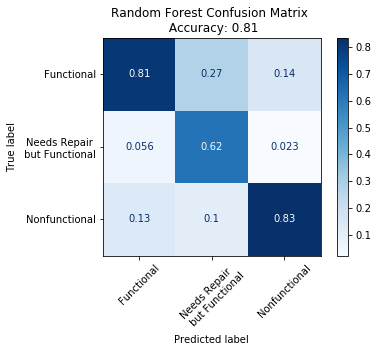

In [51]:
plot_confusion_matrix(RF_best, X_test, y_test, xticks_rotation=45, display_labels = ['Functional', 'Needs Repair \n but Functional', 'Nonfunctional'], 
                     normalize='pred', cmap='Blues')
plt.title(f'Random Forest Confusion Matrix \n Accuracy: {round(RF_best.score(X_test, y_test), 2)}')
plt.savefig('RF_confusion_matrix.png', dpi = 300, transparent = True);

In [39]:
features = list(zip(col_names, RF_best.feature_importances_))
features.sort(key = lambda x: x[1], reverse = True)
features

[('quantity_dry', 0.09880949362903063),
 ('days_since_recording', 0.08832249464641011),
 ('gps_height', 0.05764089349071237),
 ('population', 0.03706731740824866),
 ('quantity_enough', 0.033016179431580674),
 ('waterpoint_type_other', 0.02991278126463122),
 ('extraction_type_class_other', 0.029333275583992686),
 ('amount_tsh', 0.02889376628761281),
 ('district_code', 0.028753207481692016),
 ('extraction_type_other', 0.02606936943173382),
 ('quantity_insufficient', 0.017826234820594925),
 ('payment_type_never pay', 0.01500517958597537),
 ('waterpoint_type_communal standpipe', 0.014269228950360478),
 ('construction_year_bin_06-10', 0.011385104735831982),
 ('waterpoint_type_communal standpipe multiple', 0.010203517199886622),
 ('installer_DWE', 0.009778154941370699),
 ('source_spring', 0.009168773683504387),
 ('waterpoint_type_hand pump', 0.00842130335456533),
 ('installer_other', 0.008314062451679094),
 ('management_vwc', 0.008022018067145361),
 ('extraction_type_nira/tanira', 0.00794115